<h1>Melodia in Python: A Tutorial</h1>

This tutorial shows how to use the [Melodia Melody Extraction vamp plugin](http://mtg.upf.edu/technologies/melodia) directly in python.

* The tutorial assumes working knowledge of python (and that python is already installed on your system). 
* If you already have the [Melodia vamp plugin](http://mtg.upf.edu/technologies/melodia) installed, skip to step 2. 
* If you already have the [python vamp module](https://pypi.python.org/pypi/vamp) installed, skip to step 3.</p>

For further details about the Melodia algorithm itself please see:

J. Salamon and E. Gómez, "[Melody Extraction from Polyphonic Music Signals using Pitch Contour Characteristics](http://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamongomezmelodytaslp2012.pdf)", IEEE Transactions on Audio, Speech and Language Processing, 20(6):1759-1770, Aug. 2012. ([copyright notice](http://www.justinsalamon.com/publications.html#IEEE_copyright))

Created by [Justin Salamon](http://www.justinsalamon.com), January 2016.

<h2>Step 1: Install Melodia</h2>

Go to the [Melodia website](http://mtg.upf.edu/technologies/melodia), follow the link to the download page, and download the plugin. Then follow the instructions provided in the README file to install the plugin on your system.

**Tip:** and easy way to check if the plugin is installed correctly is to open [Sonic Visualiser](http://www.sonicvisualiser.org/) and then check if the plugin appears in the menu under Transform > Analysis by Category > Pitch > MELODIA - Melody Extraction...

<h2>Step 2: Install the vamp python module</h2>

```>pip install vamp```

**Tip:** if you're not already using pip to manage your python packages: https://pip.pypa.io/en/stable/

<h2>Step 3: Using Melodia in python</h2>

<h3>3.1 Necessary modules</h3>

We need to load the ```vamp``` module of course. Since the module doesn't handle audio loading, we also need something to do that. There are many ways to load audio into python, I normally use either [Essentia](http://essentia.upf.edu/) or [Librosa](https://bmcfee.github.io/librosa/). If you don't have neither installed, Librosa is probably easier to set up (```pip install librosa```). Finally, we'll use ```matplotlib``` for visualizing the extracted melody pitch contour.

In [1]:
import vamp
import librosa
# import essentia.standard as es
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function

ModuleNotFoundError: No module named 'vamp'

<h3>3.2 Loading audio</h3>

In [2]:
# This is the audio file we'll be analyzing. 
# You can download it here: http://labrosa.ee.columbia.edu/projects/melody/mirex05TrainFiles.zip
audio_file = '/Users/justin/datasets/melody/mirex05/audio/train05.wav'

In [3]:
# This is how we load audio using Essentia
# loader = es.MonoLoader(filename=audio_file, downmix = 'mix', sampleRate = 44100)
# audio = loader()

In [4]:
# This is how we load audio using Librosa
audio, sr = librosa.load(audio_file, sr=44100, mono=True)

<h3>3.3 Exracting the melody using Melodia with default parameter values</h3>

In [5]:
data = vamp.collect(audio, sr, "mtg-melodia:melodia")

In [6]:
# data is a dictionary containing one item called "vector"
data

{'vector': ( 0.002902494,
  array([-220., -220., -220., ..., -220., -220., -220.], dtype=float32))}

In [7]:
# vector is a tuple of two values: the hop size used for analysis and the array of pitch values
# Note that the hop size is *always* equal to 128/44100.0 = 2.9 ms
hop, melody = data['vector']
print(hop)
print(melody)

 0.002902494
[-220. -220. -220. ..., -220. -220. -220.]


<h3>\*\*\* SUPER IMPORTANT SUPER IMPORTANT \*\*\*</h3>
For reasons internal to the vamp architecture, THE TIMESTAMP OF THE FIRST VALUE IN THE MELODY ARRAY IS ALWAYS:

```
first_timestamp = 8 * hop = 8 * 128/44100.0 = 0.023219954648526078
```

This means that the timestamp of the pitch value at index i (starting with i=0) is given by:

```
timestamp[i] = 8 * 128/44100.0 + i * (128/44100.0)
```

So, if you want to generate a timestamp array to match the pitch values, you do it like this:

In [8]:
import numpy as np
timestamps = 8 * 128/44100.0 + np.arange(len(melody)) * (128/44100.0)

As noted above, the hop size used in Melodia is always 2.9 ms, regardless of the sampling rate of the audio being analysed (though a rate of 44100 is recommended for optimal performance). This in turn means the first timestamp is always 23.2 ms, again, regardless of the sampling rate.

<h3>3.4 Extracting the melody using Melodia with custom parameter values</h3>

In [9]:
# parameter values are specified by providing a dicionary to the optional "parameters" parameter:
params = {"minfqr": 100.0, "maxfqr": 800.0, "voicing": 0.2, "minpeaksalience": 0.0}

data = vamp.collect(audio, sr, "mtg-melodia:melodia", parameters=params)
hop, melody = data['vector']

Melodia has 4 parameters:
* **minfqr**: minimum frequency in Hertz (default 55.0)
* **maxfqr**: maximum frequency in Hertz (default 1760.0)
* **voicing**: voicing tolerance. Greater values will result in more pitch contours included in the final melody. Smaller values will result in less pitch contours included in the final melody (default 0.2).
* **minpeaksalience**: (in Sonic Visualiser "Monophonic Noise Filter") is a hack to avoid silence turning into junk contours when analyzing monophonic recordings (e.g. solo voice with no accompaniment). Generally you want to leave this untouched (default 0.0).

<h3>3.4 Plot the extracted melody</h3>

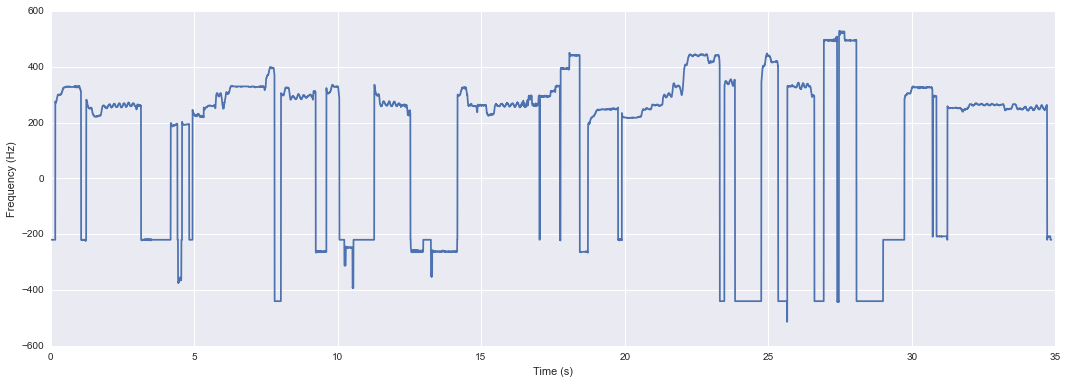

In [10]:
# Melodia returns unvoiced (=no melody) sections as negative values. So by default, we get:
plt.figure(figsize=(18,6))
plt.plot(timestamps, melody)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

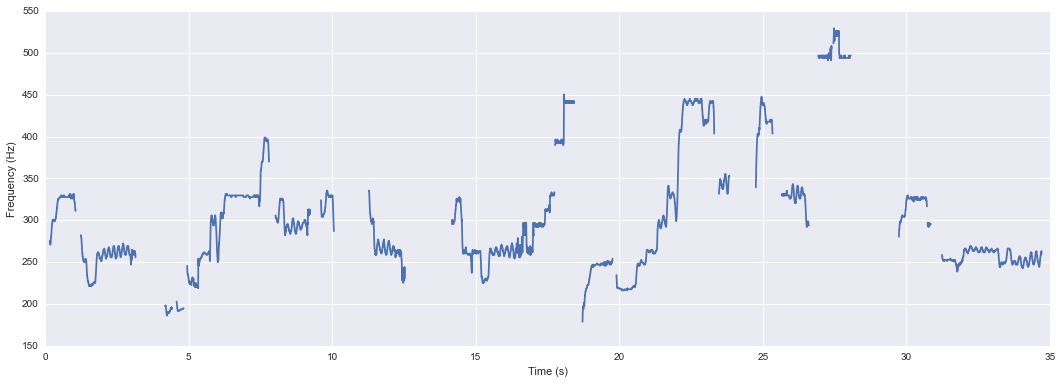

In [11]:
# A clearer option is to get rid of the negative values before plotting
melody_pos = melody[:]
melody_pos[melody<=0] = None
plt.figure(figsize=(18,6))
plt.plot(timestamps, melody_pos)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

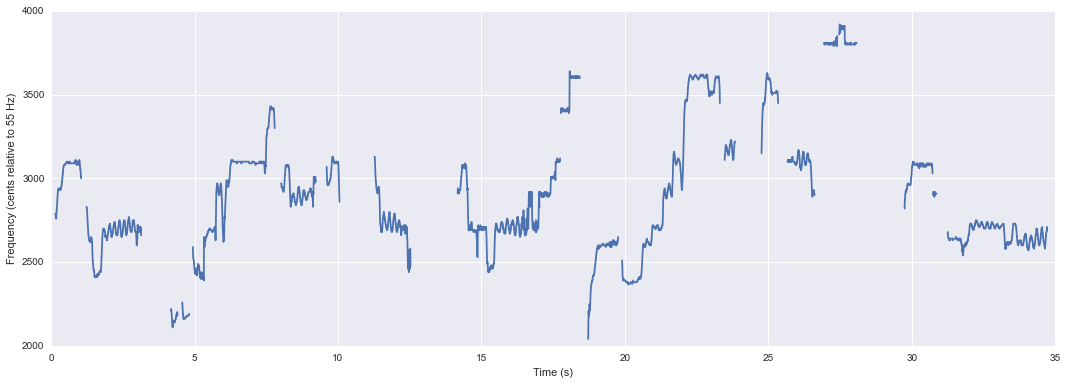

In [12]:
# Finally, you might want to plot the pitch sequence in cents rather than in Hz. 
# This especially makes sense if you are comparing two or more pitch sequences 
# to each other (e.g. comparing an estimate against a reference).
melody_cents = 1200*np.log2(melody/55.0)
melody_cents[melody<=0] = None
plt.figure(figsize=(18,6))
plt.plot(timestamps, melody_cents)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (cents relative to 55 Hz)')
plt.show()

<h2>That's all folks</h2>

For further information feel free to contact me: justin.salamon@nyu.edu (or justin.salamon@gmail.com)